# Math Question Answer Verification Competition

## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [ ]:
# # %%capture
# # This cell will take time
!pip install unsloth
# # Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 116.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
max_seq_length = 1024 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
from unsloth import FastLanguageModel
import torch

# 加载Meta-Llama-3.1-8B预训练模型
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

## Load model and wrap with LoRA adapters

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = True,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.11.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Competition dataset

In [ ]:
# download and load competition dataset
import numpy as np
torch.manual_seed(3407)
np.random.seed(3407)
from datasets import load_dataset
full_dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
dataset = full_dataset['train'].shuffle(seed=3407)

# print and see dataset
dataset
# print(dataset[0])
# print(dataset[1])
# print(dataset[2])
# print(dataset[3])
# print(dataset[4])

Dataset({
    features: ['question', 'is_correct', 'answer', 'solution'],
    num_rows: 1000000
})

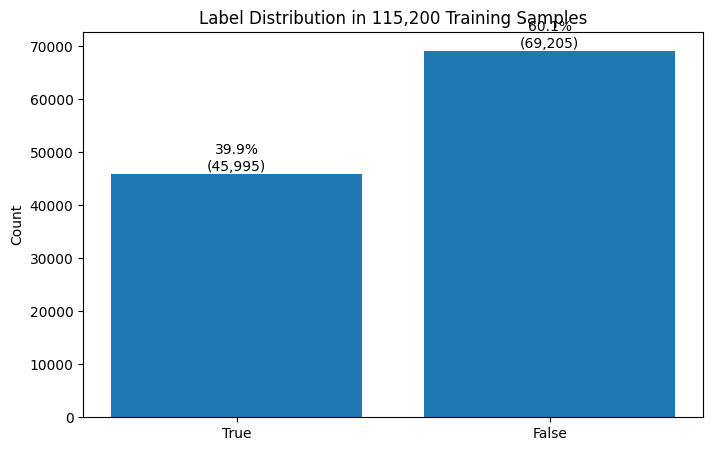


Analyzing balance for 115,200 samples that will be used in 900 steps:
Effective batch size per step: 128
True labels: 45,995 (39.9%)
False labels: 69,205 (60.1%)

This represents 11.5% of your full dataset


In [ ]:
def check_actual_training_balance(dataset, max_steps, batch_size, grad_accum_steps):
    # Calculate how many samples will actually be used in training
    effective_batch_size = batch_size * grad_accum_steps
    total_training_samples = max_steps * effective_batch_size

    # Get only the samples that will be used in training
    training_subset = dataset.select(range(min(total_training_samples, len(dataset))))

    # Get labels for the subset that will actually be trained on
    training_labels = training_subset['is_correct']

    # Count True and False labels
    label_counts = Counter(training_labels)
    total = len(training_labels)

    # Calculate percentages
    percentages = {k: (v/total)*100 for k, v in label_counts.items()}

    # Visualize
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['True', 'False'], [label_counts[True], label_counts[False]])
    plt.title(f'Label Distribution in {total_training_samples:,} Training Samples')
    plt.ylabel('Count')

    # Add count and percentage labels on bars
    for bar, (label, count) in zip(bars, label_counts.items()):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{percentages[label]:.1f}%\n({count:,})',
                ha='center', va='bottom')

    plt.show()

    print(f"\nAnalyzing balance for {total_training_samples:,} samples that will be used in {max_steps} steps:")
    print(f"Effective batch size per step: {effective_batch_size}")
    print(f"True labels: {label_counts[True]:,} ({percentages[True]:.1f}%)")
    print(f"False labels: {label_counts[False]:,} ({percentages[False]:.1f}%)")

    # Print what portion of the full dataset this represents
    coverage_percentage = (total_training_samples / len(dataset)) * 100
    print(f"\nThis represents {coverage_percentage:.1f}% of your full dataset")

# Call the function with your training parameters
check_actual_training_balance(
    dataset=dataset,
    max_steps=900,
    batch_size=32,
    grad_accum_steps=4
)

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]


Creating balanced dataset for 115,200 total samples:
Will use 57,600 samples from each class

Original dataset statistics:
True: 400,000 (40.0%)
False: 600,000 (60.0%)

Balanced dataset statistics:
True: 57,600 (50.0%)
False: 57,600 (50.0%)


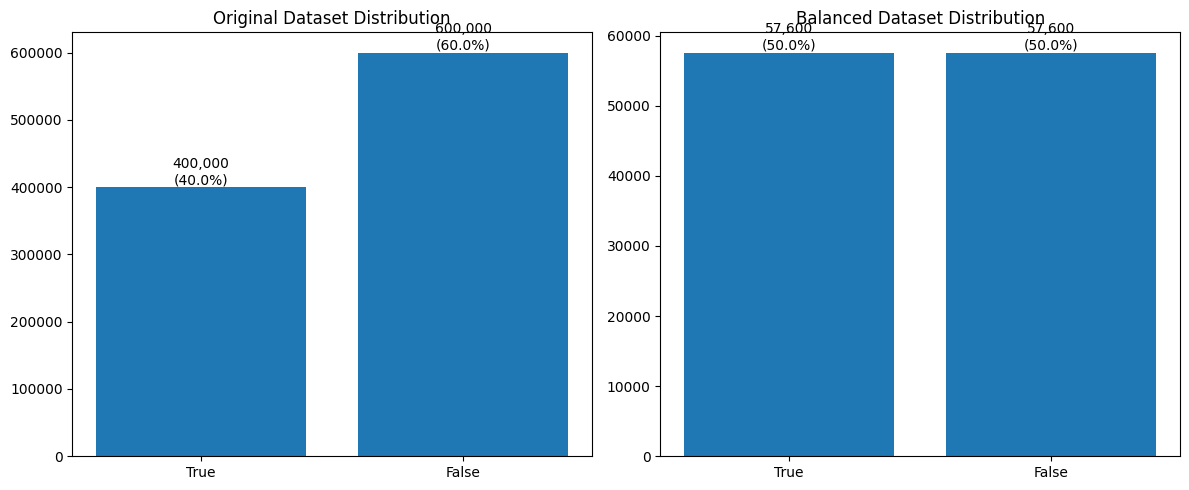

NameError: name 'formatting_prompts_func' is not defined

In [ ]:
def create_balanced_training_subset(dataset, max_steps, batch_size, grad_accum_steps):
    import numpy as np
    from datasets import Dataset

    # Calculate total samples needed for training
    samples_needed = max_steps * batch_size * grad_accum_steps

    # Separate True and False samples
    true_samples = dataset.filter(lambda x: x['is_correct'] == True)
    false_samples = dataset.filter(lambda x: x['is_correct'] == False)

    # Calculate how many samples to take from each class
    samples_per_class = samples_needed // 2

    print(f"\nCreating balanced dataset for {samples_needed:,} total samples:")
    print(f"Will use {samples_per_class:,} samples from each class")

    # Take balanced samples from each class
    true_indices = np.random.choice(len(true_samples), samples_per_class, replace=False)
    false_indices = np.random.choice(len(false_samples), samples_per_class, replace=False)

    # Select the samples
    balanced_true = true_samples.select(true_indices)
    balanced_false = false_samples.select(false_indices)

    # Combine and shuffle
    balanced_dataset = Dataset.from_dict({
        'question': balanced_true['question'] + balanced_false['question'],
        'answer': balanced_true['answer'] + balanced_false['answer'],
        'solution': balanced_true['solution'] + balanced_false['solution'],
        'is_correct': balanced_true['is_correct'] + balanced_false['is_correct']
    })

    # Shuffle the dataset
    balanced_dataset = balanced_dataset.shuffle(seed=42)

    # Print statistics
    print("\nOriginal dataset statistics:")
    original_counts = Counter(dataset['is_correct'])
    print(f"True: {original_counts[True]:,} ({original_counts[True]/len(dataset)*100:.1f}%)")
    print(f"False: {original_counts[False]:,} ({original_counts[False]/len(dataset)*100:.1f}%)")

    print("\nBalanced dataset statistics:")
    balanced_counts = Counter(balanced_dataset['is_correct'])
    print(f"True: {balanced_counts[True]:,} ({balanced_counts[True]/len(balanced_dataset)*100:.1f}%)")
    print(f"False: {balanced_counts[False]:,} ({balanced_counts[False]/len(balanced_dataset)*100:.1f}%)")

    # Visualize the balance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Original distribution
    orig_counts = [original_counts[True], original_counts[False]]
    ax1.bar(['True', 'False'], orig_counts)
    ax1.set_title('Original Dataset Distribution')
    for i, count in enumerate(orig_counts):
        ax1.text(i, count, f'{count:,}\n({count/len(dataset)*100:.1f}%)',
                ha='center', va='bottom')

    # Balanced distribution
    bal_counts = [balanced_counts[True], balanced_counts[False]]
    ax2.bar(['True', 'False'], bal_counts)
    ax2.set_title('Balanced Dataset Distribution')
    for i, count in enumerate(bal_counts):
        ax2.text(i, count, f'{count:,}\n({count/len(balanced_dataset)*100:.1f}%)',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return balanced_dataset

# Create balanced dataset with your parameters
balanced_dataset = create_balanced_training_subset(
    dataset=dataset,
    max_steps=900,
    batch_size=32,
    grad_accum_steps=4
)

# Now use this balanced dataset for training by replacing the dataset in training code:
train_dataset = balanced_dataset.map(
    formatting_prompts_func,
    batched=True,
    batch_size=64,
    num_proc=4,
    load_from_cache_file=False,
)


In [ ]:
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Your answer should follow these steps
1. Read the question carefully
### Question:
{}

2. Check the given answer
### Answer:
{}

3. Solve step by step
### Step-by-step verification:
{}

4. Verification Steps:
- Check if all given information is used correctly
- Verify calculations and mathematical operations
- Compare final answer with the given answer

5. Respond ONLY with 'True' if correct, 'False' if there are any errors.
### Output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    solution  = examples["solution"]
    output      = examples["is_correct"]
    texts = []
    for instruction, input,solution, output in zip(question, ans,solution, output):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        # text = prompt.format(instruction, input, output) + EOS_TOKEN
        text = prompt.format(instruction, input, solution, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [ ]:
# Process the randomalized training dataset and generate prompt for each datapoint
train_dataset = dataset.map(formatting_prompts_func,
                                     batched = True,
                                     batch_size=64,
                                     num_proc=4,
                                     load_from_cache_file=False,)

Map (num_proc=4):   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [ ]:
#print a smaple training example
train_dataset['text'][0]

"You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.\nYour answer should follow these steps\n1. Read the question carefully\n### Question:\nA line is parameterized by\n\\[\\begin{pmatrix} x \\\\ y \\end{pmatrix} = \\begin{pmatrix} 2 \\\\ 3 \\end{pmatrix} + t \\begin{pmatrix} -1 \\\\ 5 \\end{pmatrix}.\\]A second line is parameterized by\n\\[\\begin{pmatrix} x \\\\ y \\end{pmatrix} = \\begin{pmatrix} 0 \\\\ 7 \\end{pmatrix} + u \\begin{pmatrix} -1 \\\\ 4 \\end{pmatrix}.\\]Find the point where the lines intersect.\n\n2. Check the given answer\n### Answer:\n(2/3,4/3)\n\n3. Solve step by step\n### Step-by-step verification:\nFirst, we need to solve the system of equations\n\\[\n\\begin{aligned}\n2 - t &= s\\\\\n3 + 5t &= 7 + 4s\n\\end{aligned}\n\\]\nby eliminating s.\nWe'll use sympy.\n<llm-code>\nfrom sympy import symbols, solve\n\n# define the variables\nt, s = symbols('t s')\n\n# define the equations\nequation1 = 2 - t -

## SFT

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

# 与训练有关的重要参数都在这边调

training_args = TrainingArguments(
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        num_train_epochs = 10, # Set this for 1 full training run.
        max_steps = 200,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        eval_steps = 10,  # 每 10 个步骤进行一次评估
        seed = 42,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    )


In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
torch.cuda.empty_cache()
# small_train_dataset = train_dataset.select(range(10000))  # 取数据集的一个小样本例如使用前10000个样本
# Using the balanced dataset here
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset, # make sure the balanced dataset here
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args
)

Map (num_proc=4):   0%|          | 0/1000000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
PYTORCH_CUDA_ALLOC_CONF=expandable_segments=True
torch.cuda.empty_cache()
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 200
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,1.588100
2,1.701000
3,1.660200
4,1.536300
5,1.354600
6,1.007900
7,0.941600
8,0.848600
9,0.794900
10,0.676400


## Saving model

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [ ]:
# Sample inferene data point
test_dataset = dataset['test']
sample_ques = test_dataset['question'][0]
sample_sols = test_dataset['solution'][0]
sample_ans = test_dataset['answer'][0]

## inference

In [ ]:
# del outputs
# del tokenizer
# del trainer
# del trainer_stats

In [ ]:
torch.cuda.empty_cache()
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        # llm_int8_enable_fp32_cpu_offload=True
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


==((====))==  Unsloth 2024.11.6: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Running inference on single test
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
input_prompt = prompt.format(
        sample_ques, # ques
        sample_ans, # given answer
        sample_sols, # solution
        "", # output - leave this blank for generation! LLM willl generate is it is True or False
    )

print("Input Promt:\n", input_prompt)
inputs = tokenizer(
[
    input_prompt
], return_tensors = "pt").to("cuda")

input_shape = inputs['input_ids'].shape
input_token_len = input_shape[1] # 1 because of batch
outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True, top_p=0.9).to("cuda")
# you can get the whole generated text by uncommenting the below line
# text_generated = tokenizer.batch_decode([outputs, skip_special_tokens=True)

response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)
# response

Input Promt:
 You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Your answer should follow these steps
1. Read the question carefully
### Question:
The Parker family needs to leave the house by 5 pm for a dinner party. Mrs. Parker was waiting to get into the bathroom at 2:30 pm. Her oldest daughter used the bathroom for 45 minutes and her youngest daughter used the bathroom for another 30 minutes. Then her husband used it for 20 minutes. How much time will Mrs. Parker have to use the bathroom to leave on time?

2. Check the given answer
### Answer:
205

3. Solve step by step
### Step-by-step verification:
Let's solve this problem using Python code.
<llm-code>
minutes_per_hour = 60
minutes_left_before_5 = 5 * minutes_per_hour
total_time_spent_by_family = 45 + 30 + 20
minutes_before_5_after_family = minutes_left_before_5 - total_time_spent_by_family
minutes_before_5_after_family
</llm-code>
<llm-code-output>
205
</llm-c

In [ ]:
!pip install tqdm pandas

import os
import torch
from tqdm import tqdm
import pandas as pd
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
def create_submission(model, tokenizer, test_dataset, batch_size=4):
    FastLanguageModel.for_inference(model)
    predictions = []

    # Process test dataset in batches with progress bar
    for i in tqdm(range(0, len(test_dataset), batch_size), desc="Processing test dataset"):
        # Clear cache periodically
        if i % 100 == 0:
            torch.cuda.empty_cache()

        batch_end = min(i + batch_size, len(test_dataset))
        batch_questions = test_dataset['question'][i:batch_end]
        batch_solutions = test_dataset['solution'][i:batch_end]
        batch_answers = test_dataset['answer'][i:batch_end]

        # Create prompts for the batch
        batch_prompts = [
            prompt.format(q, a, s,"")
            for q, s, a in zip(batch_questions,batch_solutions,batch_answers)
        ]

        try:
            # Tokenize batch
            inputs = tokenizer(
                batch_prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to("cuda")

            # Generate predictions
            with torch.inference_mode():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=64,
                    top_p=0.9,
                    use_cache=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            # Process outputs
            for j in range(len(outputs)):
                input_len = len(inputs['input_ids'][j])
                response = tokenizer.decode(outputs[j][input_len:], skip_special_tokens=True).strip()
                prediction = True if 'True' in response.split()[0] else False
                predictions.append(prediction)

            # Clean up
            del inputs, outputs

        except RuntimeError as e:
            print(f"\nError in batch processing at index {i}. Switching to single example processing.")
            # Process examples one by one if batch fails
            for q, a,s in zip(batch_questions, batch_answers,batch_solutions):
                try:
                    single_prompt = prompt.format(q, a, s,"")
                    inputs = tokenizer([single_prompt], return_tensors="pt", truncation=True, max_length=512)
                    with torch.inference_mode():
                        outputs = model.generate(**inputs, max_new_tokens=64, top_p=0.9, use_cache=True)
                    response = tokenizer.decode(outputs[0][len(inputs['input_ids'][0]):], skip_special_tokens=True).strip()
                    prediction = True if 'True' in response.split()[0] else False
                    predictions.append(prediction)
                    del inputs, outputs
                    torch.cuda.empty_cache()
                except Exception as e:
                    print(f"\nError processing single example: {e}")
                    predictions.append(False)  # Default prediction in case of error

    # Create final submission DataFrame
    submission_df = pd.DataFrame({
        'ID': range(len(predictions)),
        'is_correct': predictions
    })

    if len(submission_df) != len(test_dataset):
        print(f"\nWarning: Number of predictions ({len(predictions)}) doesn't match test dataset size ({len(test_dataset)})")

    # Save submission
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission saved successfully!")
    print(f"Total predictions: {len(predictions)}")
    print("\nFirst few predictions:")
    print(submission_df.head())

    return submission_df

# Clear GPU memory before running
print("Clearing GPU memory...")
torch.cuda.empty_cache()

# Create submission
test_dataset = dataset['test']
submission = create_submission(
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_dataset,
    batch_size=25
)

Clearing GPU memory...


Processing test dataset: 100%|██████████| 400/400 [28:54<00:00,  4.34s/it]


Submission saved successfully!
Total predictions: 10000

First few predictions:
   ID  is_correct
0   0        True
1   1       False
2   2        True
3   3        True
4   4       False
